# Regional Demand Forecasting using LSTM

## Libraries

In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 17.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import optimizers
import tensorflow as tf
from numpy.random import seed
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

random_state = 0

seed(random_state)
tf.random.set_seed(random_state)

## Helper Functions

In [3]:
def series_to_supervised(data, window=7, lag=1, transform_vars=None, static_vars=None, dropnan=True):
    """
    Convert a time series dataframe into a supervised learning dataset.

    Parameters:
        data (pd.DataFrame): Original time series.
        window (int): Number of past time steps for lagging (t-1, t-2, ..., t-window).
        lag (int): Number of future steps to forecast (t, t+1, ..., t+lag-1).
        transform_vars (list): Variables to window (lag/lead).
        static_vars (list): Variables to keep at time t only (not windowed).
        dropnan (bool): Drop rows with NaN after shifting.

    Returns:
        pd.DataFrame: Supervised learning frame.
    """
    df = data.copy()
    cols = []

    # Lag features (t-window-1 to t-1)
    for i in range(window-1, 0, -1):
        shifted = df[transform_vars].shift(i)
        shifted.columns = [f'{col}(t-{i})' for col in transform_vars]
        cols.append(shifted)

    # Static features
    if static_vars:
        static = df[static_vars].copy()
        static.columns = [f'{col}' for col in static_vars]
        cols.insert(0, static)

    # Current timestep (t) for transform_vars
    if transform_vars:
        current = df[transform_vars].copy()
        current.columns = [f'{col}(t)' for col in transform_vars]
        cols.append(current)

    # Lead features (t+1 to t+lag) for transform_vars
    if lag > 1:
        for i in range(1, lag + 1):
            shifted = df[transform_vars].shift(-i)
            shifted.columns = [f'{col}(t+{i})' for col in transform_vars]
            cols.append(shifted)

    # Concatenate all
    agg = concat(cols, axis=1)

    # Drop NaNs
    if dropnan:
        agg.dropna(inplace=True)

        for col in agg.select_dtypes(include='float'): # Due to NAN integer columns casted as float
            if (agg[col] % 1 == 0).all(): # If all values in col are integers (so .0) convert back to integer
                agg[col] = agg[col].astype('int64')

    return agg

def build_lstm_model(input_shape, output_steps=16):
    model = Sequential()

    # Add return_sequences=True for stacked LSTMs
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=False))  # Last LSTM layer
    model.add(Dropout(0.3))

    # Dense layers for multi-step prediction
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_steps))  # 16 outputs for 16-day forecast

    model.compile(
        loss='mse',
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
    )
    return model

## Load and Preprocess Data for LSTM

In [4]:
# Load data
train = pd.read_csv('train_merged.csv', parse_dates=['date'])
test = pd.read_csv('test_merged.csv', parse_dates=['date'])

# Filter train for the last year data only
train = train[train['date'] >= '2017-01-01']

# Sort data by ProductFamily, Store, date
train = train.sort_values(['ProductFamily', 'Store', 'date']).reset_index(drop=True)
test = test.sort_values(['ProductFamily', 'Store', 'date']).reset_index(drop=True)

# Reorder columns
train = train[['date', 'Store', 'ProductFamily', 'IsPerishable', 'OnPromotion','Year', 'Month', 'Day', 'DayOfWeek', 'IsHoliday', 'OilPrice', 'Transactions', 'Sales']]
test = test[['date','Store', 'ProductFamily', 'IsPerishable', 'OnPromotion','Year', 'Month', 'Day', 'DayOfWeek', 'IsHoliday', 'OilPrice', 'Transactions']]

# Label encode ProductFamily globally
# Will reverse encoding in the end
le_global = LabelEncoder()
train['ProductFamily'] = le_global.fit_transform(train['ProductFamily'])
test['ProductFamily'] = le_global.transform(test['ProductFamily'])

# Scale Features and Target globally
# Will reverse Sales (Target) in the end
features_to_scale = ['OilPrice', 'Transactions', 'OnPromotion']
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train[features_to_scale] = feature_scaler.fit_transform(train[features_to_scale])
test[features_to_scale] = feature_scaler.transform(test[features_to_scale])

train[['Sales']] = target_scaler.fit_transform(train[['Sales']])

# Explicitly define features to be use for series to sequence transformation
static_features = ['Store', 'ProductFamily', 'IsPerishable']
timestep_features = ['OnPromotion','Year', 'Month', 'Day', 'DayOfWeek', 'IsHoliday', 'OilPrice', 'Transactions', 'Sales']
feature_cols = timestep_features + static_features

In [5]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

print('Min date from test set: %s' % test['date'].min().date())
print('Max date from test set: %s' % test['date'].max().date())

lag_size = (test['date'].max().date() - train['date'].max().date()).days

print('Forecast lag size', lag_size)

Min date from train set: 2017-01-01
Max date from train set: 2017-08-15
Min date from test set: 2017-08-16
Max date from test set: 2017-08-31
Forecast lag size 16


In [6]:
window = 30
lag = lag_size

all_train_sequences = []

# Loop through each (Store, ProductFamily) group
for (store, product), group in train.groupby(['Store', 'ProductFamily']):
    group = group.sort_values('date')

    # Apply transformation
    sequence = series_to_supervised(
        data=group,
        window=window,
        lag=lag,
        transform_vars=timestep_features,
        static_vars=static_features,
        dropnan=True
    )
    all_train_sequences.append(sequence)

# Concatenate all sequances in one dataframe
train_sequence = pd.concat(all_train_sequences, axis=0).reset_index(drop=True)

In [7]:
all_test_sequences = []

for (store, product), test_group in test.groupby(['Store', 'ProductFamily']):
    train_group = train[(train['Store'] == store) & (train['ProductFamily'] == product)].sort_values('date')
    test_group = test_group.sort_values('date')

    if len(train_group) < window:
        continue  # Not enough history

    # Last `window` rows with full Sales
    history = train_group.iloc[-window:].copy()

    # Future test rows (Sales missing, other features present)
    future = test_group.copy()
    if 'Sales' not in future.columns:
        future['Sales'] = np.nan

    # Concatenate train window + test
    combined = pd.concat([history, future], axis=0).reset_index(drop=True)

    # Transform to supervised
    transformed = series_to_supervised(
        data=combined,
        window=window,
        lag=lag,
        transform_vars=timestep_features,
        static_vars=static_features,
        dropnan=False
    )

    # Filter row where Sales(t+1..t+lag) are NaN but Sales(t) is present
    lead_sales_cols = [f'Sales(t+{i})' for i in range(1, lag+1)]
    last_valid = transformed[
        (transformed['Sales(t)'].notna()) &
        (transformed[lead_sales_cols].isna().all(axis=1))
    ].tail(1)

    if not last_valid.empty:
        all_test_sequences.append(last_valid)

# Combine all test inputs
test_sequence = pd.concat(all_test_sequences, axis=0).reset_index(drop=True)

# Since no drop during transformation integer cols not converted back
for col in test_sequence.select_dtypes(include='float'): # Due to NAN integer columns casted as float
    if (test_sequence[col] % 1 == 0).all(): # If all values in col are integers (so .0) convert back to integer
        test_sequence[col] = test_sequence[col].astype('int64')

In [ ]:
train_sequence.head(5)

,Store,ProductFamily,IsPerishable,OnPromotion(t-29),Year(t-29),Month(t-29),Day(t-29),DayOfWeek(t-29),IsHoliday(t-29),OilPrice(t-29),Transactions(t-29),Sales(t-29),OnPromotion(t-28),Year(t-28),Month(t-28),Day(t-28),DayOfWeek(t-28),IsHoliday(t-28),OilPrice(t-28),Transactions(t-28),Sales(t-28),OnPromotion(t-27),Year(t-27),Month(t-27),Day(t-27),DayOfWeek(t-27),IsHoliday(t-27),OilPrice(t-27),Transactions(t-27),Sales(t-27),OnPromotion(t-26),Year(t-26),Month(t-26),Day(t-26),DayOfWeek(t-26),IsHoliday(t-26),OilPrice(t-26),Transactions(t-26),Sales(t-26),OnPromotion(t-25),Year(t-25),Month(t-25),Day(t-25),DayOfWeek(t-25),IsHoliday(t-25),OilPrice(t-25),Transactions(t-25),Sales(t-25),OnPromotion(t-24),Year(t-24),Month(t-24),Day(t-24),DayOfWeek(t-24),IsHoliday(t-24),OilPrice(t-24),Transactions(t-24),Sales(t-24),OnPromotion(t-23),Year(t-23),Month(t-23),Day(t-23),DayOfWeek(t-23),IsHoliday(t-23),OilPrice(t-23),Transactions(t-23),Sales(t-23),OnPromotion(t-22),Year(t-22),Month(t-22),Day(t-22),DayOfWeek(t-22),IsHoliday(t-22),OilPrice(t-22),Transactions(t-22),Sales(t-22),OnPromotion(t-21),Year(t-21),Month(t-21),Day(t-21),DayOfWeek(t-21),IsHoliday(t-21),OilPrice(t-21),Transactions(t-21),Sales(t-21),OnPromotion(t-20),Year(t-20),Month(t-20),Day(t-20),DayOfWeek(t-20),IsHoliday(t-20),OilPrice(t-20),Transactions(t-20),Sales(t-20),OnPromotion(t-19),Year(t-19),Month(t-19),Day(t-19),DayOfWeek(t-19),IsHoliday(t-19),OilPrice(t-19),Transactions(t-19),Sales(t-19),OnPromotion(t-18),Year(t-18),Month(t-18),Day(t-18),DayOfWeek(t-18),IsHoliday(t-18),OilPrice(t-18),Transactions(t-18),Sales(t-18),OnPromotion(t-17),Year(t-17),Month(t-17),Day(t-17),DayOfWeek(t-17),IsHoliday(t-17),OilPrice(t-17),Transactions(t-17),Sales(t-17),OnPromotion(t-16),Year(t-16),Month(t-16),Day(t-16),DayOfWeek(t-16),IsHoliday(t-16),OilPrice(t-16),Transactions(t-16),Sales(t-16),OnPromotion(t-15),Year(t-15),Month(t-15),Day(t-15),DayOfWeek(t-15),IsHoliday(t-15),OilPrice(t-15),Transactions(t-15),Sales(t-15),OnPromotion(t-14),Year(t-14),Month(t-14),Day(t-14),DayOfWeek(t-14),IsHoliday(t-14),OilPrice(t-14),Transactions(t-14),Sales(t-14),OnPromotion(t-13),Year(t-13),Month(t-13),Day(t-13),DayOfWeek(t-13),IsHoliday(t-13),OilPrice(t-13),Transactions(t-13),Sales(t-13),OnPromotion(t-12),Year(t-12),Month(t-12),Day(t-12),DayOfWeek(t-12),IsHoliday(t-12),OilPrice(t-12),Transactions(t-12),Sales(t-12),OnPromotion(t-11),Year(t-11),Month(t-11),Day(t-11),DayOfWeek(t-11),IsHoliday(t-11),OilPrice(t-11),Transactions(t-11),Sales(t-11),OnPromotion(t-10),Year(t-10),Month(t-10),Day(t-10),DayOfWeek(t-10),IsHoliday(t-10),OilPrice(t-10),Transactions(t-10),Sales(t-10),OnPromotion(t-9),Year(t-9),Month(t-9),Day(t-9),DayOfWeek(t-9),IsHoliday(t-9),OilPrice(t-9),Transactions(t-9),Sales(t-9),OnPromotion(t-8),Year(t-8),Month(t-8),Day(t-8),DayOfWeek(t-8),IsHoliday(t-8),OilPrice(t-8),Transactions(t-8),Sales(t-8),OnPromotion(t-7),Year(t-7),Month(t-7),Day(t-7),DayOfWeek(t-7),IsHoliday(t-7),OilPrice(t-7),Transactions(t-7),Sales(t-7),OnPromotion(t-6),Year(t-6),Month(t-6),Day(t-6),DayOfWeek(t-6),IsHoliday(t-6),OilPrice(t-6),Transactions(t-6),Sales(t-6),OnPromotion(t-5),Year(t-5),Month(t-5),Day(t-5),DayOfWeek(t-5),IsHoliday(t-5),OilPrice(t-5),Transactions(t-5),Sales(t-5),OnPromotion(t-4),Year(t-4),Month(t-4),Day(t-4),DayOfWeek(t-4),IsHoliday(t-4),OilPrice(t-4),Transactions(t-4),Sales(t-4),OnPromotion(t-3),Year(t-3),Month(t-3),Day(t-3),DayOfWeek(t-3),IsHoliday(t-3),OilPrice(t-3),Transactions(t-3),Sales(t-3),OnPromotion(t-2),Year(t-2),Month(t-2),Day(t-2),DayOfWeek(t-2),IsHoliday(t-2),OilPrice(t-2),Transactions(t-2),Sales(t-2),OnPromotion(t-1),Year(t-1),Month(t-1),Day(t-1),DayOfWeek(t-1),IsHoliday(t-1),OilPrice(t-1),Transactions(t-1),Sales(t-1),OnPromotion(t),Year(t),Month(t),Day(t),DayOfWeek(t),IsHoliday(t),OilPrice(t),Transactions(t),Sales(t),OnPromotion(t+1),Year(t+1),Month(t+1),Day(t+1),DayOfWeek(t+1),IsHoliday(t+1),OilPrice(t+1),Transactions(t+1),Sales(t+1),OnPromotion(t+2),Year(t+2),Month(t+2),Day(t+2),DayOfWeek(t+2),IsHoliday(t+2),OilPric

In [ ]:
test_sequence.head(5)

,Store,ProductFamily,IsPerishable,OnPromotion(t-29),Year(t-29),Month(t-29),Day(t-29),DayOfWeek(t-29),IsHoliday(t-29),OilPrice(t-29),Transactions(t-29),Sales(t-29),OnPromotion(t-28),Year(t-28),Month(t-28),Day(t-28),DayOfWeek(t-28),IsHoliday(t-28),OilPrice(t-28),Transactions(t-28),Sales(t-28),OnPromotion(t-27),Year(t-27),Month(t-27),Day(t-27),DayOfWeek(t-27),IsHoliday(t-27),OilPrice(t-27),Transactions(t-27),Sales(t-27),OnPromotion(t-26),Year(t-26),Month(t-26),Day(t-26),DayOfWeek(t-26),IsHoliday(t-26),OilPrice(t-26),Transactions(t-26),Sales(t-26),OnPromotion(t-25),Year(t-25),Month(t-25),Day(t-25),DayOfWeek(t-25),IsHoliday(t-25),OilPrice(t-25),Transactions(t-25),Sales(t-25),OnPromotion(t-24),Year(t-24),Month(t-24),Day(t-24),DayOfWeek(t-24),IsHoliday(t-24),OilPrice(t-24),Transactions(t-24),Sales(t-24),OnPromotion(t-23),Year(t-23),Month(t-23),Day(t-23),DayOfWeek(t-23),IsHoliday(t-23),OilPrice(t-23),Transactions(t-23),Sales(t-23),OnPromotion(t-22),Year(t-22),Month(t-22),Day(t-22),DayOfWeek(t-22),IsHoliday(t-22),OilPrice(t-22),Transactions(t-22),Sales(t-22),OnPromotion(t-21),Year(t-21),Month(t-21),Day(t-21),DayOfWeek(t-21),IsHoliday(t-21),OilPrice(t-21),Transactions(t-21),Sales(t-21),OnPromotion(t-20),Year(t-20),Month(t-20),Day(t-20),DayOfWeek(t-20),IsHoliday(t-20),OilPrice(t-20),Transactions(t-20),Sales(t-20),OnPromotion(t-19),Year(t-19),Month(t-19),Day(t-19),DayOfWeek(t-19),IsHoliday(t-19),OilPrice(t-19),Transactions(t-19),Sales(t-19),OnPromotion(t-18),Year(t-18),Month(t-18),Day(t-18),DayOfWeek(t-18),IsHoliday(t-18),OilPrice(t-18),Transactions(t-18),Sales(t-18),OnPromotion(t-17),Year(t-17),Month(t-17),Day(t-17),DayOfWeek(t-17),IsHoliday(t-17),OilPrice(t-17),Transactions(t-17),Sales(t-17),OnPromotion(t-16),Year(t-16),Month(t-16),Day(t-16),DayOfWeek(t-16),IsHoliday(t-16),OilPrice(t-16),Transactions(t-16),Sales(t-16),OnPromotion(t-15),Year(t-15),Month(t-15),Day(t-15),DayOfWeek(t-15),IsHoliday(t-15),OilPrice(t-15),Transactions(t-15),Sales(t-15),OnPromotion(t-14),Year(t-14),Month(t-14),Day(t-14),DayOfWeek(t-14),IsHoliday(t-14),OilPrice(t-14),Transactions(t-14),Sales(t-14),OnPromotion(t-13),Year(t-13),Month(t-13),Day(t-13),DayOfWeek(t-13),IsHoliday(t-13),OilPrice(t-13),Transactions(t-13),Sales(t-13),OnPromotion(t-12),Year(t-12),Month(t-12),Day(t-12),DayOfWeek(t-12),IsHoliday(t-12),OilPrice(t-12),Transactions(t-12),Sales(t-12),OnPromotion(t-11),Year(t-11),Month(t-11),Day(t-11),DayOfWeek(t-11),IsHoliday(t-11),OilPrice(t-11),Transactions(t-11),Sales(t-11),OnPromotion(t-10),Year(t-10),Month(t-10),Day(t-10),DayOfWeek(t-10),IsHoliday(t-10),OilPrice(t-10),Transactions(t-10),Sales(t-10),OnPromotion(t-9),Year(t-9),Month(t-9),Day(t-9),DayOfWeek(t-9),IsHoliday(t-9),OilPrice(t-9),Transactions(t-9),Sales(t-9),OnPromotion(t-8),Year(t-8),Month(t-8),Day(t-8),DayOfWeek(t-8),IsHoliday(t-8),OilPrice(t-8),Transactions(t-8),Sales(t-8),OnPromotion(t-7),Year(t-7),Month(t-7),Day(t-7),DayOfWeek(t-7),IsHoliday(t-7),OilPrice(t-7),Transactions(t-7),Sales(t-7),OnPromotion(t-6),Year(t-6),Month(t-6),Day(t-6),DayOfWeek(t-6),IsHoliday(t-6),OilPrice(t-6),Transactions(t-6),Sales(t-6),OnPromotion(t-5),Year(t-5),Month(t-5),Day(t-5),DayOfWeek(t-5),IsHoliday(t-5),OilPrice(t-5),Transactions(t-5),Sales(t-5),OnPromotion(t-4),Year(t-4),Month(t-4),Day(t-4),DayOfWeek(t-4),IsHoliday(t-4),OilPrice(t-4),Transactions(t-4),Sales(t-4),OnPromotion(t-3),Year(t-3),Month(t-3),Day(t-3),DayOfWeek(t-3),IsHoliday(t-3),OilPrice(t-3),Transactions(t-3),Sales(t-3),OnPromotion(t-2),Year(t-2),Month(t-2),Day(t-2),DayOfWeek(t-2),IsHoliday(t-2),OilPrice(t-2),Transactions(t-2),Sales(t-2),OnPromotion(t-1),Year(t-1),Month(t-1),Day(t-1),DayOfWeek(t-1),IsHoliday(t-1),OilPrice(t-1),Transactions(t-1),Sales(t-1),OnPromotion(t),Year(t),Month(t),Day(t),DayOfWeek(t),IsHoliday(t),OilPrice(t),Transactions(t),Sales(t),OnPromotion(t+1),Year(t+1),Month(t+1),Day(t+1),DayOfWeek(t+1),IsHoliday(t+1),OilPrice(t+1),Transactions(t+1),Sales(t+1),OnPromotion(t+2),Year(t+2),Month(t+2),Day(t+2),DayOfWeek(t+2),IsHoliday(t+2),OilPric

## LSTM

In [8]:
# Features and Target split
target_cols = ['Sales(t+%d)' % i for i in range(1, lag_size + 1)]

X_train = train_sequence.drop(target_cols, axis=1)
y_train = train_sequence[target_cols]

X_test = test_sequence.drop(target_cols, axis=1)

print('Train set shape', X_train.shape)
print('Test set shape', X_test.shape)

Train set shape (324324, 401)
Test set shape (1782, 401)


In [9]:
# Convert from 2D to 3D for LSTM:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create validation split from train dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train.values, test_size=0.2, random_state=random_state)

# Type shows up as object, can't pass type object in LSTM
y_train = y_train.astype(np.float64)
y_valid = y_valid.astype(np.float64)

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
print('Test set shape', X_test.shape)

Train set shape (259459, 401, 1)
Validation set shape (64865, 401, 1)
Test set shape (1782, 401, 1)


In [ ]:
epochs = 100
batch = 128
lr = 0.001
callback = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

lstm = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_history = lstm.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[callback, reduce_lr], epochs=epochs, batch_size=batch, verbose=1)

Epoch 1/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 180s 85ms/step - loss: 0.7487 - mae: 0.3978 - val_loss: 0.1603 - val_mae: 0.1880 - learning_rate: 0.0010
Epoch 2/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 210s 90ms/step - loss: 0.1697 - mae: 0.1693 - val_loss: 0.1291 - val_mae: 0.1261 - learning_rate: 0.0010
Epoch 3/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 196s 87ms/step - loss: 0.1295 - mae: 0.1217 - val_loss: 0.1016 - val_mae: 0.1223 - learning_rate: 0.0010
Epoch 4/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 178s 88ms/step - loss: 0.1085 - mae: 0.1047 - val_loss: 0.0867 - val_mae: 0.1102 - learning_rate: 0.0010
Epoch 5/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 183s 90ms/step - loss: 0.0966 - mae: 0.0987 - val_loss: 0.0825 - val_mae: 0.1026 - learning_rate: 0.0010
Epoch 6/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 202s 90ms/step - loss: 0.0812 - mae: 0.0903 - val_loss: 0.0643 - val_mae: 0.0772 - learning_rate: 0.0010
Epoch 7/100
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 197s 88ms/step - loss: 0.0718 - mae: 0.0857 - val_loss: 0.0687 - val_

In [ ]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 401, 256)       │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 401, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,609,586 (6.14 MB)

 Trainable params: 536,528 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,073,058 (4.09 MB)

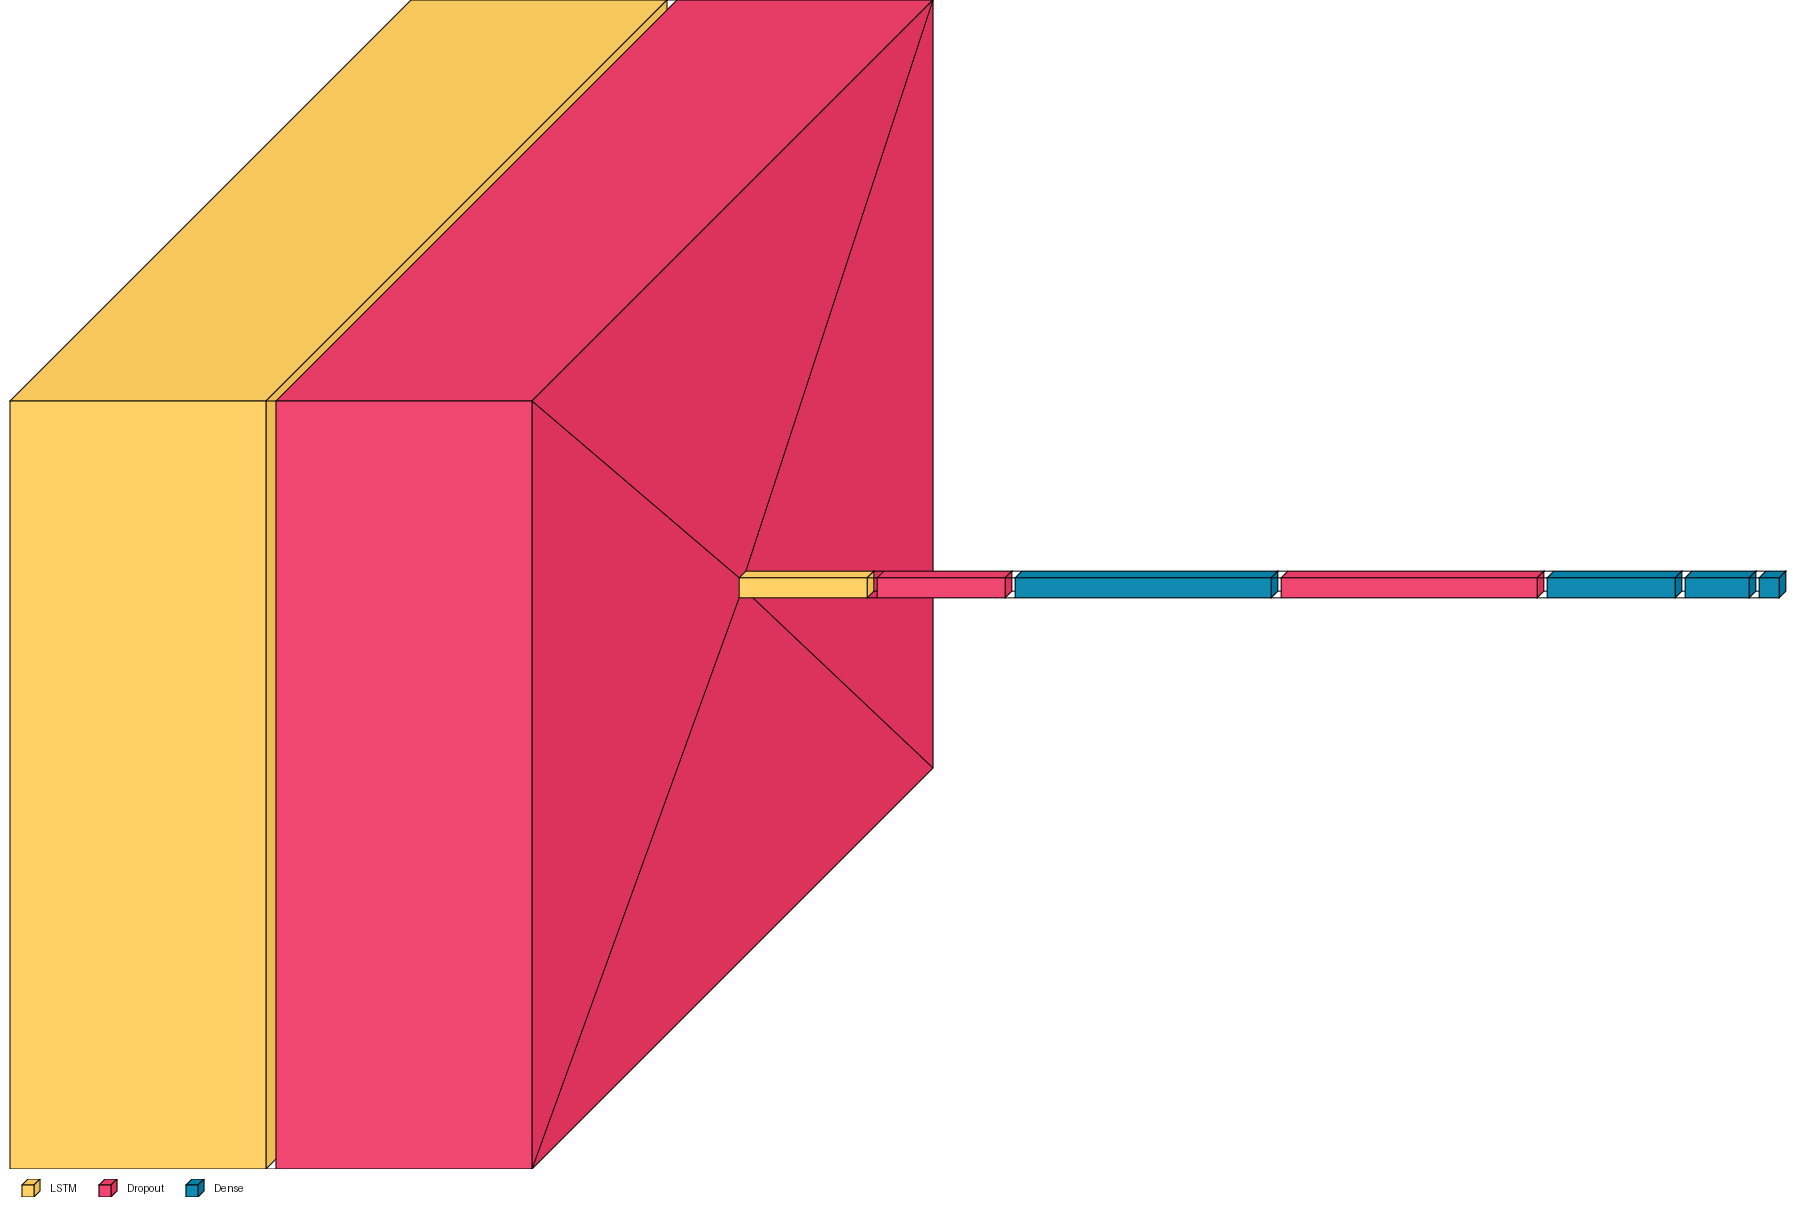

In [10]:
import visualkeras
visualkeras.layered_view(lstm, legend=True,
                        to_file='lstm_architecture.png',
                        scale_xy=3, scale_z=1)

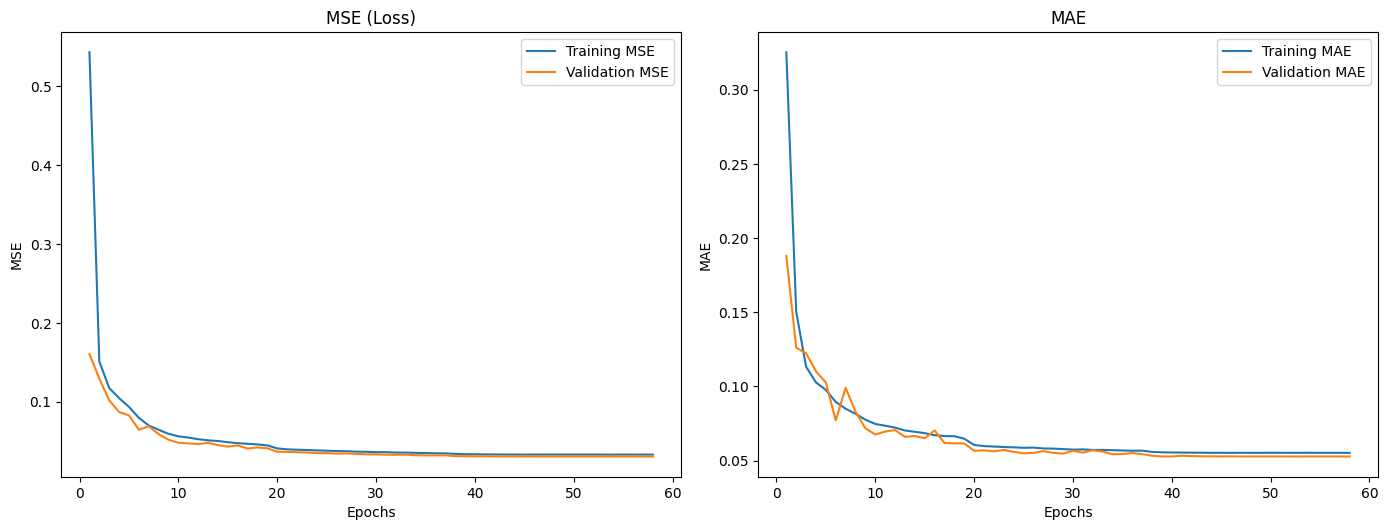

In [ ]:
history = lstm_history.history
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(14, 10))

# Plot loss (MSE)
plt.subplot(2, 2, 1)
plt.plot(epochs, history['loss'], label='Training MSE')
plt.plot(epochs, history['val_loss'], label='Validation MSE')
plt.title('MSE (Loss)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(epochs, history['mae'], label='Training MAE')
plt.plot(epochs, history['val_mae'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig("LSTM_Train_History.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
demand_forecast = lstm.predict(X_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [ ]:
flattened_forecast = demand_forecast.flatten().reshape(-1, 1)
test['Demand'] = flattened_forecast
test['ProductFamily'] = le_global.inverse_transform(test['ProductFamily'])
test[['Demand']] = target_scaler.inverse_transform(test[['Demand']])
test = test.drop(['OnPromotion', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsHoliday', 'OilPrice', 'Transactions'], axis=1)
print(test.head(10))

        date  Store ProductFamily  IsPerishable     Demand
0 2017-08-16      1    AUTOMOTIVE             0   9.985541
1 2017-08-17      1    AUTOMOTIVE             0  10.667884
2 2017-08-18      1    AUTOMOTIVE             0  10.616736
3 2017-08-19      1    AUTOMOTIVE             0  10.818305
4 2017-08-20      1    AUTOMOTIVE             0  10.783210
5 2017-08-21      1    AUTOMOTIVE             0  10.548255
6 2017-08-22      1    AUTOMOTIVE             0  11.000800
7 2017-08-23      1    AUTOMOTIVE             0  10.236793
8 2017-08-24      1    AUTOMOTIVE             0  10.582770
9 2017-08-25      1    AUTOMOTIVE             0  10.582831


In [ ]:
future_sales = test.copy()
print(future_sales.groupby('ProductFamily')['Demand'].agg(['min', 'max', 'mean', 'median', 'std', 'count']))

                                  min           max         mean      median  \
ProductFamily                                                                  
AUTOMOTIVE                   7.912330   4981.172363   391.478882   16.702080   
BABY CARE                    7.427100  11883.298828   802.874695   99.430412   
BEAUTY                       6.735694   4841.370605   307.148193   16.353722   
BEVERAGES                    7.673621   6594.736816   574.982300   24.588875   
BOOKS                        8.629889   7695.969727   609.189148   37.391014   
BREAD/BAKERY                 6.190131   8412.983398   372.558990   22.832039   
CELEBRATION                  6.916236   8131.338379   491.630066   20.883049   
CLEANING                     6.238776   3054.127197   152.507538   10.628318   
DAIRY                        7.504554   3421.078369   280.813019   12.471015   
DELI                         6.018653   4478.316895   267.846954   17.098946   
EGGS                         8.327704   

In [ ]:
previous_sales = pd.read_csv('train_merged.csv', parse_dates=['date'])
print(previous_sales.groupby('ProductFamily')['Sales'].agg(['min', 'max', 'mean', 'median', 'std', 'count']))

                                  min         max         mean     median  \
ProductFamily                                                               
AUTOMOTIVE                     -4.000     255.000     6.086636     4.0000   
BABY CARE                       0.000     116.000     0.110266     0.0000   
BEAUTY                         -1.000     136.000     3.706896     2.0000   
BEVERAGES                  -12240.000   25413.000  2380.005332  1779.0000   
BOOKS                          -1.000      51.000     0.070596     0.0000   
BREAD/BAKERY                    0.000    4551.298   462.238301   400.0000   
CELEBRATION                   -41.000    1783.000     8.350151     3.0000   
CLEANING                    -2891.000   11377.000  1069.843755   937.0000   
DAIRY                        -453.000    5636.000   707.469458   519.0000   
DELI                            0.000    2118.325   264.506785   218.2130   
EGGS                            0.000    3110.000   171.014306   131.0000   

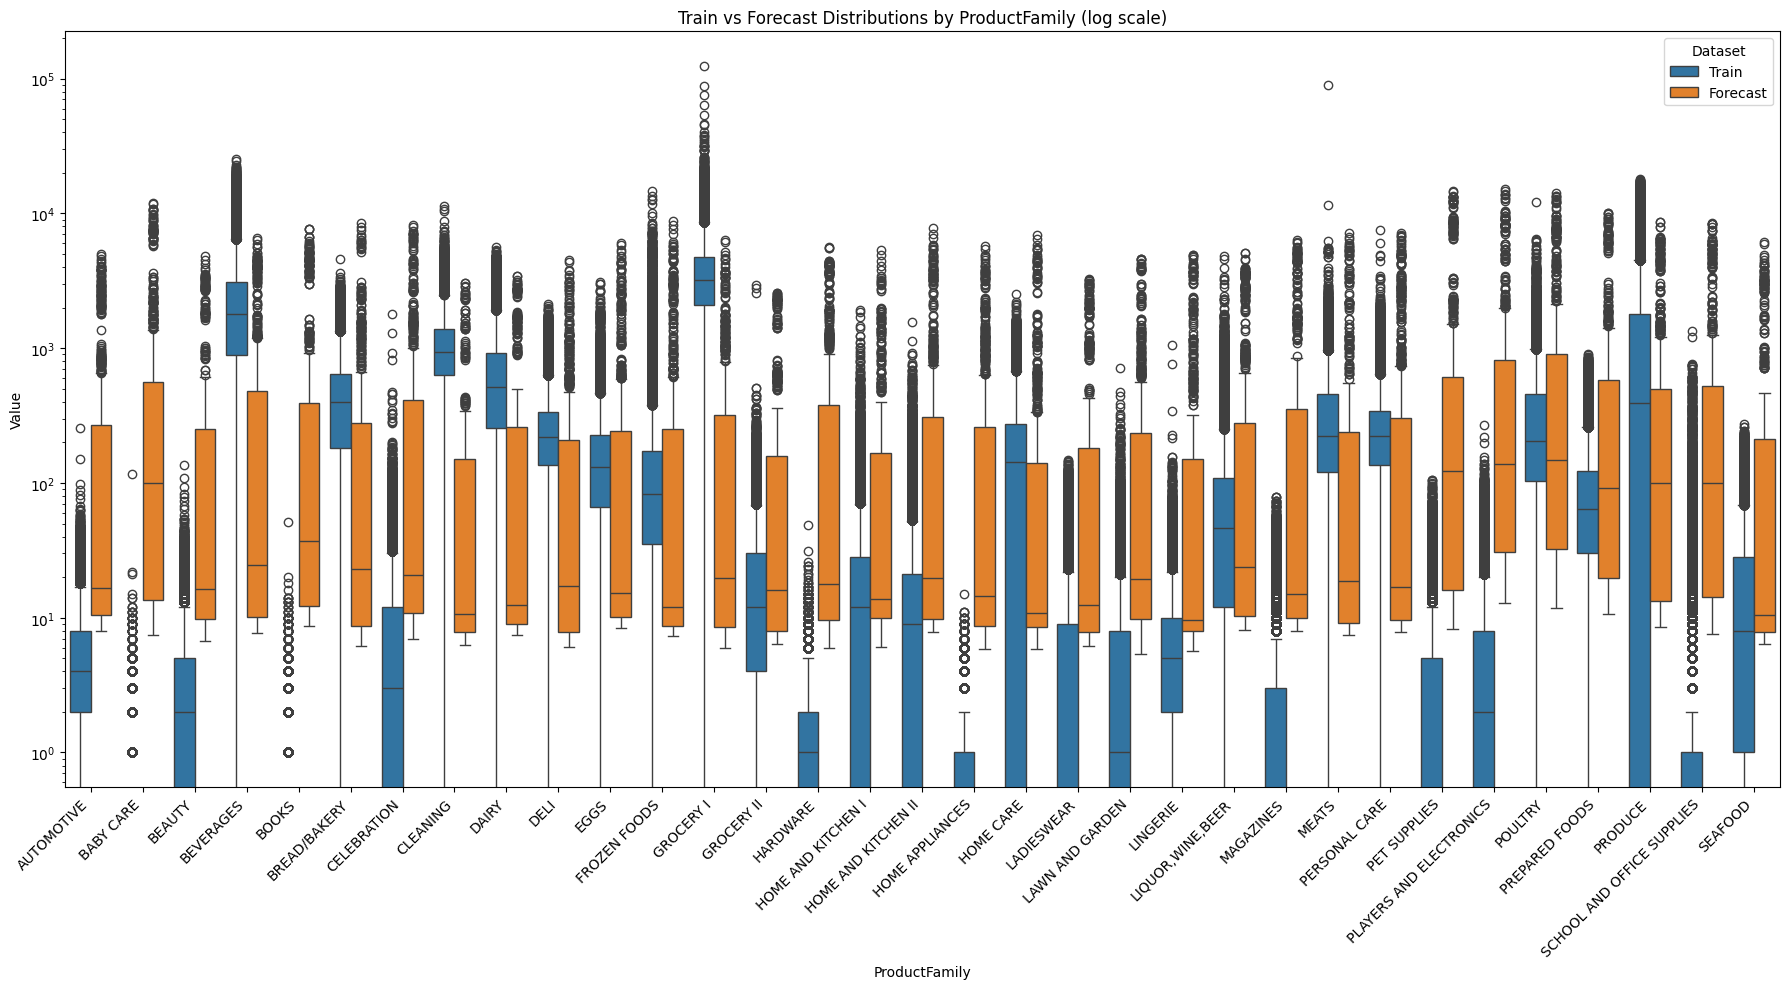

In [ ]:
sales_distribution = previous_sales[['ProductFamily', 'Sales']].copy()
demand_distribution = future_sales[['ProductFamily', 'Demand']].copy()

sales_distribution = sales_distribution.rename(columns={'Sales': 'Value'})
demand_distribution = demand_distribution.rename(columns={'Demand': 'Value'})

sales_distribution['Dataset'] = 'Train'
demand_distribution['Dataset'] = 'Forecast'

combined = pd.concat([sales_distribution, demand_distribution], ignore_index=True)

plt.figure(figsize=(18, 10))
sns.boxplot(data=combined, x='ProductFamily', y='Value', hue='Dataset')

plt.yscale('log')  # Log scale for wide value ranges
plt.xticks(rotation=45, ha='right')
plt.title('Train vs Forecast Distributions by ProductFamily (log scale)')
plt.tight_layout()
plt.savefig("Sales_vs_Demand_Distributions.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
future_sales.to_csv('demand_forecasting.csv', index=False)